## 8. Make cleaned chord dataset

This notebook converts numpy files containing cleaned numpy representations of MIDI piano tracks (cleaned meaning middle 3 octaves and transposed to the key of C) into the "chord" representation, in which a timestep is only included if it is "different enough" from the previous (defined below).

In addition, I also introduce a technique to reduce the necessary vocabulary size. After determining the top `k` frequent chords, for every other chord, I determine if the notes present in that chord is a superset of a chord in the `k` most frequent tokens. If it is, then I replace it with the more common chord, since the more common chord is a simplified version of the less frequent one, so its harmonic function will be the same.

In [3]:
import numpy as np
import os
from pathlib import Path
from PIL import Image
from music21 import stream, chord, duration
from tqdm import tqdm
from collections import Counter
import random
import re

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

Define where to find cleaned numpy files from notebook `06-midi-processing.ipynb`, and where to save the chord-ified versions.

In [4]:
NP_CLEANED_FILEPATH = Path('midi-np-augmented/')
NP_FILES = [NP_CLEANED_FILEPATH / file for file in os.listdir(NP_CLEANED_FILEPATH)]
NP_CHORDS = Path('np-chords-augmented/')
NP_CHORDS.mkdir(exist_ok=True)

### Define method for extracting chords

Load an example and inspect:

In [5]:
arr = np.load(NP_FILES[0])

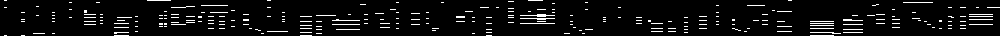

In [6]:
Image.fromarray(arr[:1000].astype(np.uint8).T * 255)

In [7]:
def is_valid_chord(timestep):
    ''' Loose restriction; only has to be at least 3 notes '''
    return np.sum(timestep) >= 3

In [8]:
def different_enough(timestep_1, timestep_2, min_new_notes=2):
    ''' Two chords are different enough if neither is a subset of the other, and there are at least
        min_new_notes in the second chord '''
    if timestep_1 is None:
        return True
    notes_in_1 = set(np.where(timestep_1 == 1)[0])
    notes_in_2 = set(np.where(timestep_2 == 1)[0])
    # One can't be subset of another
    is_subset = notes_in_1.issubset(notes_in_2) or notes_in_2.issubset(notes_in_1)
    new_notes = notes_in_2.difference(notes_in_1)
    return not is_subset and len(new_notes) >= min_new_notes

In [9]:
def get_chords(arr):
    ''' Convert a whole piano roll into different-enough timesteps '''
    last_chord = None
    chords = []
    for i, timestep in enumerate(arr):
        if is_valid_chord(timestep) and different_enough(last_chord, timestep):
            chords.append(timestep)
            last_chord = timestep
    return np.array(chords)

In [10]:
chords = get_chords(arr)

Visualize an example:

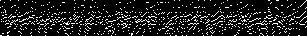

In [11]:
Image.fromarray(chords[:1000].astype(np.uint8).T * 255)

### Code from `06-midi-processing.ipynb`

In [14]:
index_to_step = ['C', 'D-', 'D', 'E-', 'E', 'F', 'G-', 'G', 'A-', 'A', 'B-', 'B', ]

def pitch_index_to_pitch_str(pitch_index):
    pitch_index += 9
    return index_to_step[pitch_index % 12] + str(pitch_index // 12)

In [15]:
def arr_to_midi(arr, savepath):
    score = stream.Score()
    for i, timestep in enumerate(arr):
        notes = np.where(timestep == 1)[0]
        notes_str = [pitch_index_to_pitch_str(idx + 27) for idx in notes]
        chord_ = chord.Chord(notes_str)
        chord_.duration = duration.Duration('quarter')
        chord_.offset = i
        score.append(chord_)
    score.write('midi', savepath)

### Save chordified versions as numpy

In [16]:
for file in tqdm(NP_FILES):
    arr = np.load(file)
    chords = get_chords(arr)
    np.save(NP_CHORDS / file.name, chords)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3408/3408 [04:35<00:00, 12.39it/s]


### Create combined (big) numpy file of all tracks for analysis

In [19]:
total_length = 0
for chord_file in tqdm(os.listdir(NP_CHORDS)):
    arr = np.load(NP_CHORDS / chord_file)
    total_length += len(arr)
combined = np.zeros((total_length, 36))
i = 0
for chord_file in tqdm(os.listdir(NP_CHORDS)):
    arr = np.load(NP_CHORDS / chord_file)
    combined[i:i+len(arr),:] = arr
    i += len(arr)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3408/3408 [00:01<00:00, 2879.59it/s]


In [21]:
combined = np.array(combined, dtype=np.uint8)

In [22]:
combined.shape

(796200, 36)

Save and load for future reference

In [24]:
np.save('combined/chords_augmented.npy', combined)

In [12]:
combined = np.load('combined/chords_augmented.npy')

Convert to text for statistical analysis

In [14]:
txtified = [''.join([str(x) for x in row]) for row in tqdm(combined)]

100%|█████████████████████████████████████████████████████████████████████████████████████████| 796200/796200 [00:21<00:00, 36753.76it/s]


Now we'll count the frequency of the tokens and analyze its distribution.

In [15]:
c = Counter(txtified)

In [16]:
tft = sorted(list(dict(c).items()), key=lambda x: -x[1])

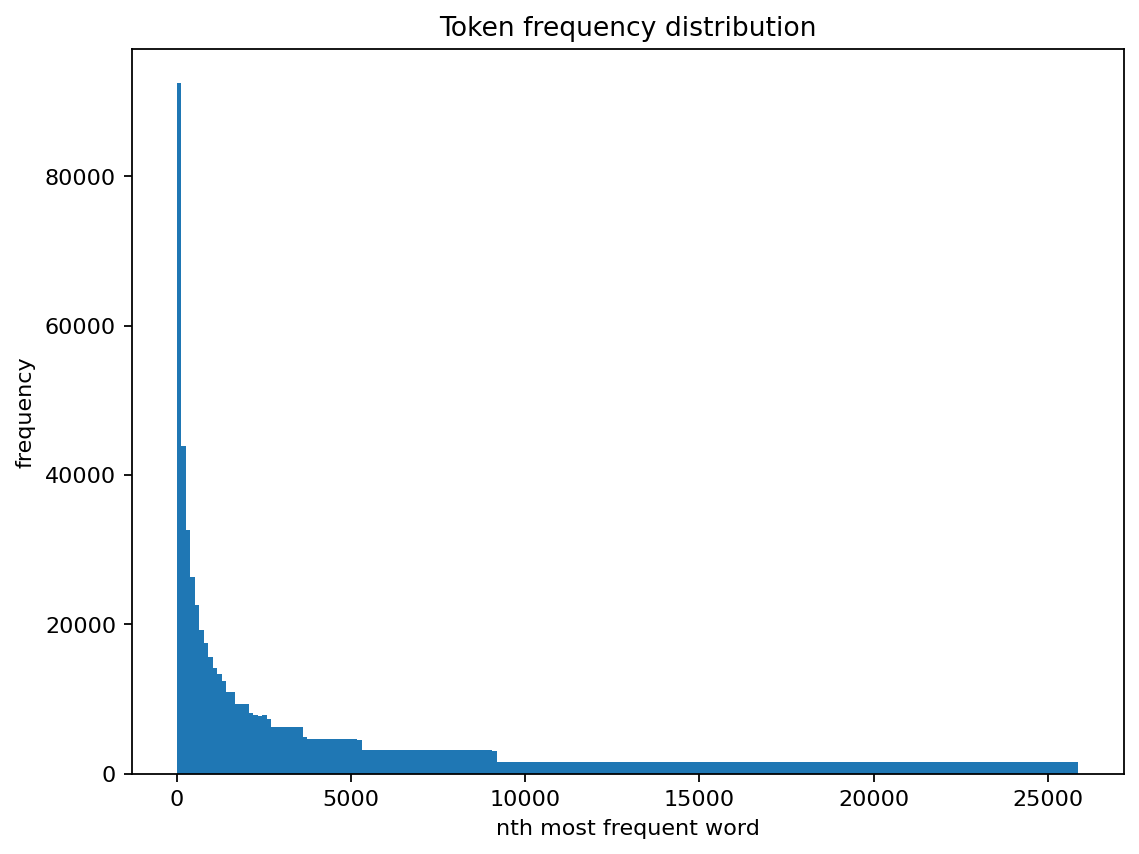

In [18]:
val = np.arange(len(tft))
weight = [pair[1] for pair in tft]
figure(figsize=(8, 6), dpi=80)
plt.hist(val, weights=weight, bins=200)
plt.xlabel('nth most frequent word')
plt.ylabel('frequency')
plt.title('Token frequency distribution')
plt.show()

Looking at the distribution above, we can choose an appropriate vocabulary size. For the `augmented` dataset, 8000 seems to be a good cutoff.

In [19]:
vocab_size = 8000

In [46]:
# Get most common words
common = [tok[0] for tok in tft[:vocab_size]]

Save and load common words as txt file for future use

In [21]:
suffix = '_aug'

In [47]:
with open(f'top_{vocab_size}{suffix}.txt', 'w') as f:
    f.write('\n'.join(common))

In [22]:
with open(f'top_{vocab_size}{suffix}.txt', 'r') as f:
    common = f.read().split('\n')

In [23]:
def is_subset(string_1, string_2):
    for char_1, char_2 in zip(string_1, string_2):
        if char_1 == '1' and char_2 == '0':
            return False
    return True

In [24]:
def get_alternative(string, common):
    ''' Given a string and the common tokens, propose an alternative '''
    alternatives = [s for s in common if is_subset(s, string)]
    if not alternatives:
        return None
    # Choose randomly if there are multiple
    idx = int(random.random() * len(alternatives))
    return alternatives[idx]

## Reduce vocabulary size with subset trick and save to txt files

In [26]:
CHORDS_TXT_CLEANED_DIR = Path('chords-txt-augmented/')
CHORDS_TXT_CLEANED_DIR.mkdir(exist_ok=True)

In [ ]:
for chord_file in tqdm(os.listdir(NP_CHORDS)):
    arr = np.load(NP_CHORDS / chord_file)
    txtified = [''.join([str(x) for x in row]) for row in arr]
    cleaned = []
    for tok in txtified:
        if tok not in common:
            alternative = get_alternative(tok, common)
            if not alternative:
                cleaned.append(tok)
            else:
                cleaned.append(alternative)
        else:
            cleaned.append(tok)
    cleaned_str = ' '.join(cleaned) + ' '
    cleaned_str = re.sub(r'(\w+? )\1+', r'\1', cleaned_str)
    with open(CHORDS_TXT_CLEANED_DIR / f"{chord_file[:-4]}.txt", 'w') as f:
        f.write(cleaned_str)

### Calculate percent of tokens that cannot be represented by a common token

In [27]:
unk_count = 0
total_count = 0
for chord_file in tqdm(os.listdir(CHORDS_TXT_CLEANED_DIR)):
    chords = open(CHORDS_TXT_CLEANED_DIR / chord_file, 'r').read().split()
    for chord in chords:
        if chord not in common:
            unk_count += 1
    total_count += len(chords)

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 3408/3408 [01:10<00:00, 48.31it/s]


In [28]:
print(f'Proportion unknown: {unk_count / total_count} ({unk_count}/{total_count})')

Proportion unknown: 0.007196211406347835 (5712/793751)
